Group - 1 Expert System for Mask&Hyginene
Student 1 : Miten Mistry - Technical Lead
Student 2 : Roshika Pant - Figures Tables & Presentation
Student 3 : Haripriya Chalicheemala - Report & Storytelling


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [2]:
img_size = (224, 224)
batch_size = 32
initial_epochs = 10       # you can increase later
fine_tune_epochs = 10
initial_learning_rate = 1e-3
fine_tune_learning_rate = 1e-4
n_base = 3                # number of base learners

train_dir = "data/train"
val_dir = "data/val"
test_dir = "data/test"

# Create output directory for saving graphs
output_dir = "output_graphs"
os.makedirs(output_dir, exist_ok=True)
print(f"\n✓ Output directory created: {output_dir}\n")


✓ Output directory created: output_graphs



In [3]:
all_classes = set()
for split_dir in [train_dir, val_dir, test_dir]:
    if os.path.exists(split_dir):
        classes = [
            d for d in os.listdir(split_dir)
            if os.path.isdir(os.path.join(split_dir, d))
        ]
        all_classes.update(classes)

all_classes = sorted(list(all_classes))
print("\n" + "="*70)
print(f"Detected classes across all splits: {all_classes}")
print(f"Total number of classes: {len(all_classes)}")
print("="*70 + "\n")



Detected classes across all splits: ['.ipynb_checkpoints', 'incorrect_mask', 'with_mask', 'without_mask']
Total number of classes: 4



In [4]:
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    classes=all_classes,
    shuffle=True,
    seed=42
)

val_gen = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    classes=all_classes,
    shuffle=False
)

test_gen = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    classes=all_classes,
    shuffle=False
)

num_classes = len(train_gen.class_indices)
print("\n" + "="*70)
print("Generator Information:")
print("="*70)
print(f"Number of classes: {num_classes}")
print(f"Class mapping: {train_gen.class_indices}")
print(f"\nTrain samples: {train_gen.samples}")
print(f"Val samples:   {val_gen.samples}")
print(f"Test samples:  {test_gen.samples}")
print("="*70 + "\n")


Found 2066 images belonging to 4 classes.
Found 2066 images belonging to 4 classes.
Found 2066 images belonging to 4 classes.

Generator Information:
Number of classes: 4
Class mapping: {'.ipynb_checkpoints': 0, 'incorrect_mask': 1, 'with_mask': 2, 'without_mask': 3}

Train samples: 2066
Val samples:   2066
Test samples:  2066



In [5]:
def build_base_model(name_suffix=""):
    base_model = MobileNetV2(
        input_shape=img_size + (3,),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    inputs = tf.keras.Input(shape=img_size + (3,))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D(name=f"gap_{name_suffix}")(x)
    x = layers.BatchNormalization(name=f"bn1_{name_suffix}")(x)
    x = layers.Dropout(0.5, name=f"do1_{name_suffix}")(x)
    x = layers.Dense(256, activation='relu', name=f"dense1_{name_suffix}")(x)
    x = layers.BatchNormalization(name=f"bn2_{name_suffix}")(x)
    x = layers.Dropout(0.3, name=f"do2_{name_suffix}")(x)
    outputs = layers.Dense(
        num_classes,
        activation='softmax',
        name=f"pred_{name_suffix}"
    )(x)

    model = models.Model(inputs, outputs, name=f"mobilenetv2_{name_suffix}")

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model, base_model


In [6]:
callbacks_common = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

base_models = []
base_histories = []  # to store histories for plotting later

for i in range(n_base):
    print("\n" + "="*70)
    print(f"TRAINING BASE MODEL {i+1}/{n_base}")
    print("="*70 + "\n")

    model_i, base_i = build_base_model(name_suffix=f"m{i+1}")
    checkpoint_i = ModelCheckpoint(
        f"base_model_{i+1}.keras",
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )

    history_phase1 = model_i.fit(
        train_gen,
        epochs=initial_epochs,
        validation_data=val_gen,
        callbacks=callbacks_common + [checkpoint_i],
        verbose=1
    )

    # Fine-tuning part of MobileNetV2
    fine_tune_at = 100
    base_i.trainable = True
    for layer in base_i.layers[:fine_tune_at]:
        layer.trainable = False

    model_i.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=fine_tune_learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    history_phase2 = model_i.fit(
        train_gen,
        epochs=initial_epochs + fine_tune_epochs,
        initial_epoch=len(history_phase1.history['loss']),
        validation_data=val_gen,
        callbacks=callbacks_common + [checkpoint_i],
        verbose=1
    )

    # Store combined history for this base model
    history_combined = {
        'loss': history_phase1.history['loss'] + history_phase2.history['loss'],
        'accuracy': history_phase1.history['accuracy'] + history_phase2.history['accuracy'],
        'val_loss': history_phase1.history['val_loss'] + history_phase2.history['val_loss'],
        'val_accuracy': history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy']
    }
    base_histories.append(history_combined)

    base_models.append(model_i)



TRAINING BASE MODEL 1/3



/opt/miniconda3/envs/mask_env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.7849 - loss: 0.6529
Epoch 1: val_accuracy improved from None to 0.97725, saving model to base_model_1.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 34s 499ms/step - accuracy: 0.8959 - loss: 0.3290 - val_accuracy: 0.9773 - val_loss: 0.0744 - learning_rate: 0.0010
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.9526 - loss: 0.1894
Epoch 2: val_accuracy improved from 0.97725 to 0.99129, saving model to base_model_1.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 33s 508ms/step - accuracy: 0.9608 - loss: 0.1445 - val_accuracy: 0.9913 - val_loss: 0.0312 - learning_rate: 0.0010
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.9680 - loss: 0.0932
Epoch 3: val_accuracy improved from 0.99129 to 0.99274, saving model to base_model_1.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 33s 506ms/step - accuracy: 0.9661 - loss: 0.0968 - val_accuracy: 0.9927 - val_loss: 0.0237 - learning_rate: 0.0010
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms

In [7]:
def get_stacked_features(models_list, generator):
    """Return stacked probabilities for all samples in generator."""
    generator.reset()
    preds_list = []
    for m in models_list:
        preds = m.predict(generator, verbose=1)
        preds_list.append(preds)
    stacked = np.concatenate(preds_list, axis=1)  # (N, n_base * num_classes)
    return stacked

train_gen.reset()
X_meta_train = get_stacked_features(base_models, train_gen)
y_meta_train = train_gen.classes

val_gen.reset()
X_meta_val = get_stacked_features(base_models, val_gen)
y_meta_val = val_gen.classes

test_gen.reset()
X_meta_test = get_stacked_features(base_models, test_gen)
y_meta_test = test_gen.classes

print("\nStacked feature shapes:")
print("X_meta_train:", X_meta_train.shape)
print("X_meta_val:  ", X_meta_val.shape)
print("X_meta_test: ", X_meta_test.shape)

65/65 ━━━━━━━━━━━━━━━━━━━━ 19s 292ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 19s 288ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 19s 289ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 12s 188ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 12s 189ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 12s 188ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 12s 185ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 12s 187ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 12s 186ms/step

Stacked feature shapes:
X_meta_train: (2066, 12)
X_meta_val:   (2066, 12)
X_meta_test:  (2066, 12)


In [8]:
input_dim = X_meta_train.shape[1]

meta_input = tf.keras.Input(shape=(input_dim,))
x = layers.Dense(128, activation='relu')(meta_input)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
meta_output = layers.Dense(num_classes, activation='softmax')(x)

meta_model = models.Model(meta_input, meta_output, name="meta_learner")

meta_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

meta_callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        "meta_learner.keras",
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("\n" + "="*70)
print("TRAINING META-LEARNER")
print("="*70 + "\n")

history_meta = meta_model.fit(
    X_meta_train, y_meta_train,
    validation_data=(X_meta_val, y_meta_val),
    epochs=30,
    batch_size=64,
    callbacks=meta_callbacks,
    verbose=1
)


TRAINING META-LEARNER

Epoch 1/30
 1/33 ━━━━━━━━━━━━━━━━━━━━ 15s 471ms/step - accuracy: 0.2344 - loss: 2.2418
Epoch 1: val_accuracy improved from None to 0.33398, saving model to meta_learner.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2682 - loss: 1.7411 - val_accuracy: 0.3340 - val_loss: 1.2690
Epoch 2/30
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3438 - loss: 1.5677
Epoch 2: val_accuracy did not improve from 0.33398
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3107 - loss: 1.4894 - val_accuracy: 0.3340 - val_loss: 1.2022
Epoch 3/30
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4375 - loss: 1.3877
Epoch 3: val_accuracy improved from 0.33398 to 0.33979, saving model to meta_learner.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3311 - loss: 1.4319 - val_accuracy: 0.3398 - val_loss: 1.1471
Epoch 4/30
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2500 - loss: 1.4225
Epoch 4: val_accuracy improved from 0.33979 to 0.65005, saving

In [9]:
def safe_classification_report(y_true, y_pred, all_classes, digits=4):
    unique_true = set(y_true)
    unique_pred = set(y_pred)
    present_classes = sorted(unique_true | unique_pred)

    print("="*70)
    print("CLASS ANALYSIS")
    print("="*70)
    print(f"Total classes defined: {len(all_classes)}")
    print(f"Classes in test data: {len(present_classes)}")
    print(f"\nAll classes: {all_classes}")
    print(f"Present class indices: {present_classes}")

    all_class_indices = set(range(len(all_classes)))
    missing_class_indices = all_class_indices - set(present_classes)

    if missing_class_indices:
        missing_classes = [all_classes[i] for i in sorted(missing_class_indices)]
        print(f"\n⚠️  Missing classes (no samples in test set): {missing_classes}")

    print("\n" + "="*70)
    print("CLASSIFICATION REPORT")
    print("="*70)

    present_target_names = [all_classes[i] for i in present_classes]

    report = classification_report(
        y_true,
        y_pred,
        labels=present_classes,
        target_names=present_target_names,
        digits=digits
    )
    print(report)

    if missing_class_indices:
        print("Note: Classes with no samples in test set are excluded from the report.")
    return present_classes, present_target_names

def plot_confusion_matrix_safe(y_true, y_pred, all_classes, present_classes=None, save_path=None):
    """
    Plot confusion matrix and optionally save to file
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        all_classes: List of all class names
        present_classes: List of present class indices
        save_path: Path to save the figure (e.g., 'output_graphs/confusion_matrix.png')
    """
    if present_classes is None:
        present_classes = sorted(set(y_true) | set(y_pred))

    cm = confusion_matrix(y_true, y_pred, labels=present_classes)
    present_class_names = [all_classes[i] for i in present_classes]

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=present_class_names,
        yticklabels=present_class_names,
        cbar_kws={'label': 'Count'}
    )
    plt.xlabel('Predicted', fontsize=12, fontweight='bold')
    plt.ylabel('True', fontsize=12, fontweight='bold')
    plt.title('Confusion Matrix (Meta-learner)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    # Save if path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Confusion matrix saved to: {save_path}")
    
    plt.show()
    plt.close()

    cm_df = pd.DataFrame(
        cm,
        index=[f"true_{c}" for c in present_class_names],
        columns=[f"pred_{c}" for c in present_class_names]
    )
    return cm_df

def per_class_accuracy_table(y_true, y_pred, all_classes):
    rows = []
    for i, class_name in enumerate(all_classes):
        class_mask = (y_true == i)
        n_samples = int(np.sum(class_mask))
        if n_samples > 0:
            class_acc = accuracy_score(y_true[class_mask], y_pred[class_mask])
            rows.append({
                "class": class_name,
                "samples": n_samples,
                "accuracy": class_acc,
                "accuracy_percent": class_acc * 100.0
            })
        else:
            rows.append({
                "class": class_name,
                "samples": 0,
                "accuracy": None,
                "accuracy_percent": None
            })
    df = pd.DataFrame(rows)
    return df

def plot_per_class_accuracy_bar(df, save_path=None):
    """
    Plot per-class accuracy as bar chart
    
    Args:
        df: DataFrame with columns ['class', 'accuracy_percent']
        save_path: Path to save the figure
    """
    # Filter only classes with data
    df_valid = df[df['accuracy_percent'].notna()].copy()
    
    plt.figure(figsize=(12, 6))
    colors = plt.cm.viridis(np.linspace(0, 1, len(df_valid)))
    
    bars = plt.bar(df_valid['class'], df_valid['accuracy_percent'], color=colors, edgecolor='black')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', fontweight='bold')
    
    plt.xlabel('Class', fontsize=12, fontweight='bold')
    plt.ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    plt.title('Per-Class Accuracy', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 105)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Per-class accuracy bar chart saved to: {save_path}")
    
    plt.show()
    plt.close()



EVALUATION ON TEST SET (META-LEARNER)

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - accuracy: 0.9255 - loss: 0.9721

Test Loss: 0.9721
Test Accuracy: 0.9255 (92.55%)

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step
Sklearn Accuracy Score: 0.9255 (92.55%)

CLASS ANALYSIS
Total classes defined: 4
Classes in test data: 3

All classes: ['.ipynb_checkpoints', 'incorrect_mask', 'with_mask', 'without_mask']
Present class indices: [np.int32(1), np.int32(2), np.int32(3)]

⚠️  Missing classes (no samples in test set): ['.ipynb_checkpoints']

CLASSIFICATION REPORT
                precision    recall  f1-score   support

incorrect_mask     0.9926    0.7826    0.8752       690
     with_mask     0.8372    0.9986    0.9108       690
  without_mask     0.9771    0.9956    0.9863       686

      accuracy                         0.9255      2066
     macro avg     0.9356    0.9256    0.9241      2066
  weighted avg     0.9356    0.9255    0.9240      2066

Note: Classes with no samples in test set are exclude

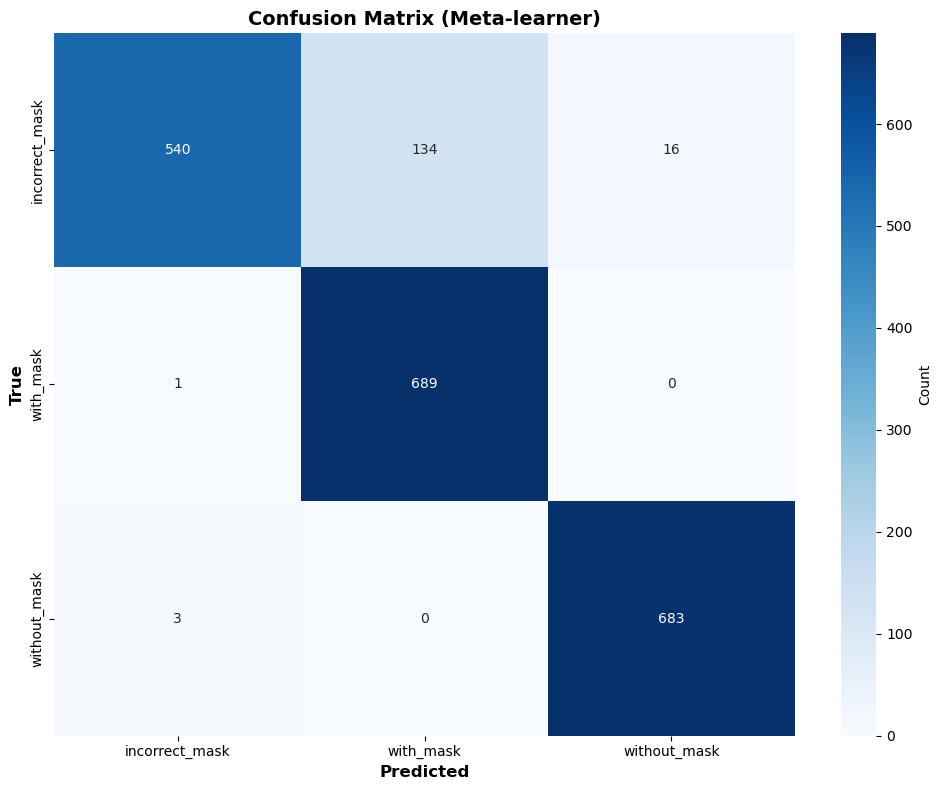


PER-CLASS ACCURACY (TABLE DATAFRAME)
                class  samples  accuracy  accuracy_percent
0  .ipynb_checkpoints        0       NaN               NaN
1      incorrect_mask      690  0.782609         78.260870
2           with_mask      690  0.998551         99.855072
3        without_mask      686  0.995627         99.562682
✓ Per-class accuracy bar chart saved to: output_graphs/per_class_accuracy.png


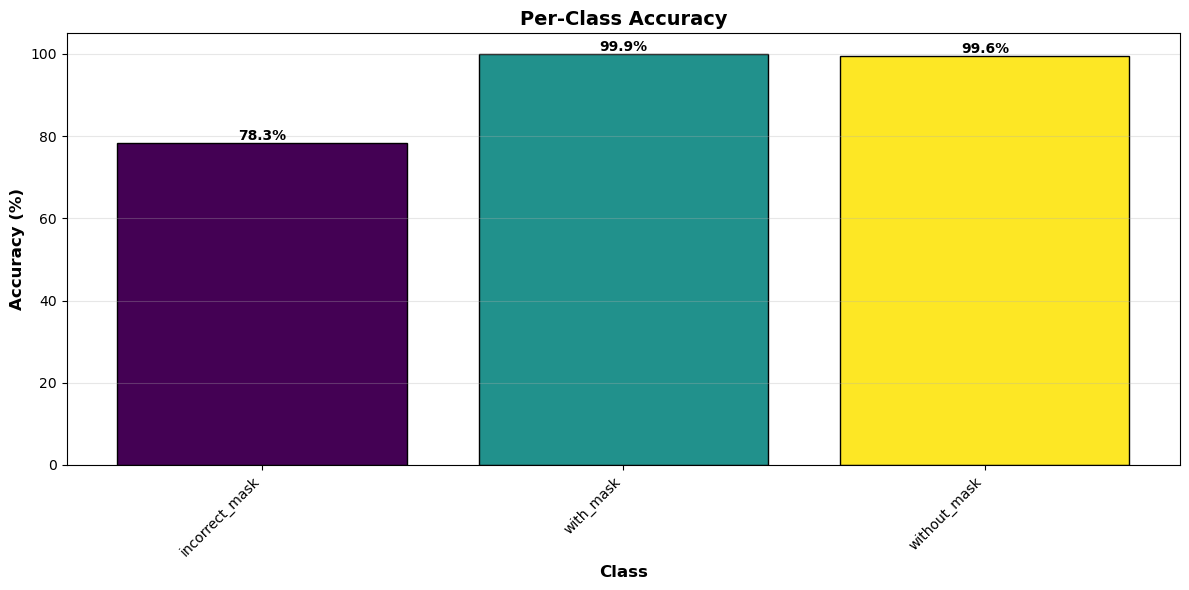

In [10]:
print("\n" + "="*70)
print("EVALUATION ON TEST SET (META-LEARNER)")
print("="*70 + "\n")

test_loss, test_acc = meta_model.evaluate(X_meta_test, y_meta_test, verbose=1)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)\n")

y_prob_meta = meta_model.predict(X_meta_test, verbose=1)
y_pred_meta = np.argmax(y_prob_meta, axis=1)

acc_score = accuracy_score(y_meta_test, y_pred_meta)
print(f"Sklearn Accuracy Score: {acc_score:.4f} ({acc_score*100:.2f}%)\n")

present_classes, present_names = safe_classification_report(
    y_meta_test,
    y_pred_meta,
    all_classes,
    digits=4
)

# Plot and save confusion matrix
cm_df = plot_confusion_matrix_safe(
    y_meta_test,
    y_pred_meta,
    all_classes,
    present_classes,
    save_path=os.path.join(output_dir, "confusion_matrix.png")
)

per_class_df = per_class_accuracy_table(
    y_meta_test,
    y_pred_meta,
    all_classes
)

print("\n" + "="*70)
print("PER-CLASS ACCURACY (TABLE DATAFRAME)")
print("="*70)
print(per_class_df)

# Plot and save per-class accuracy bar chart
plot_per_class_accuracy_bar(
    per_class_df,
    save_path=os.path.join(output_dir, "per_class_accuracy.png")
)

✓ Training history plot saved to: output_graphs/training_history_all_models.png


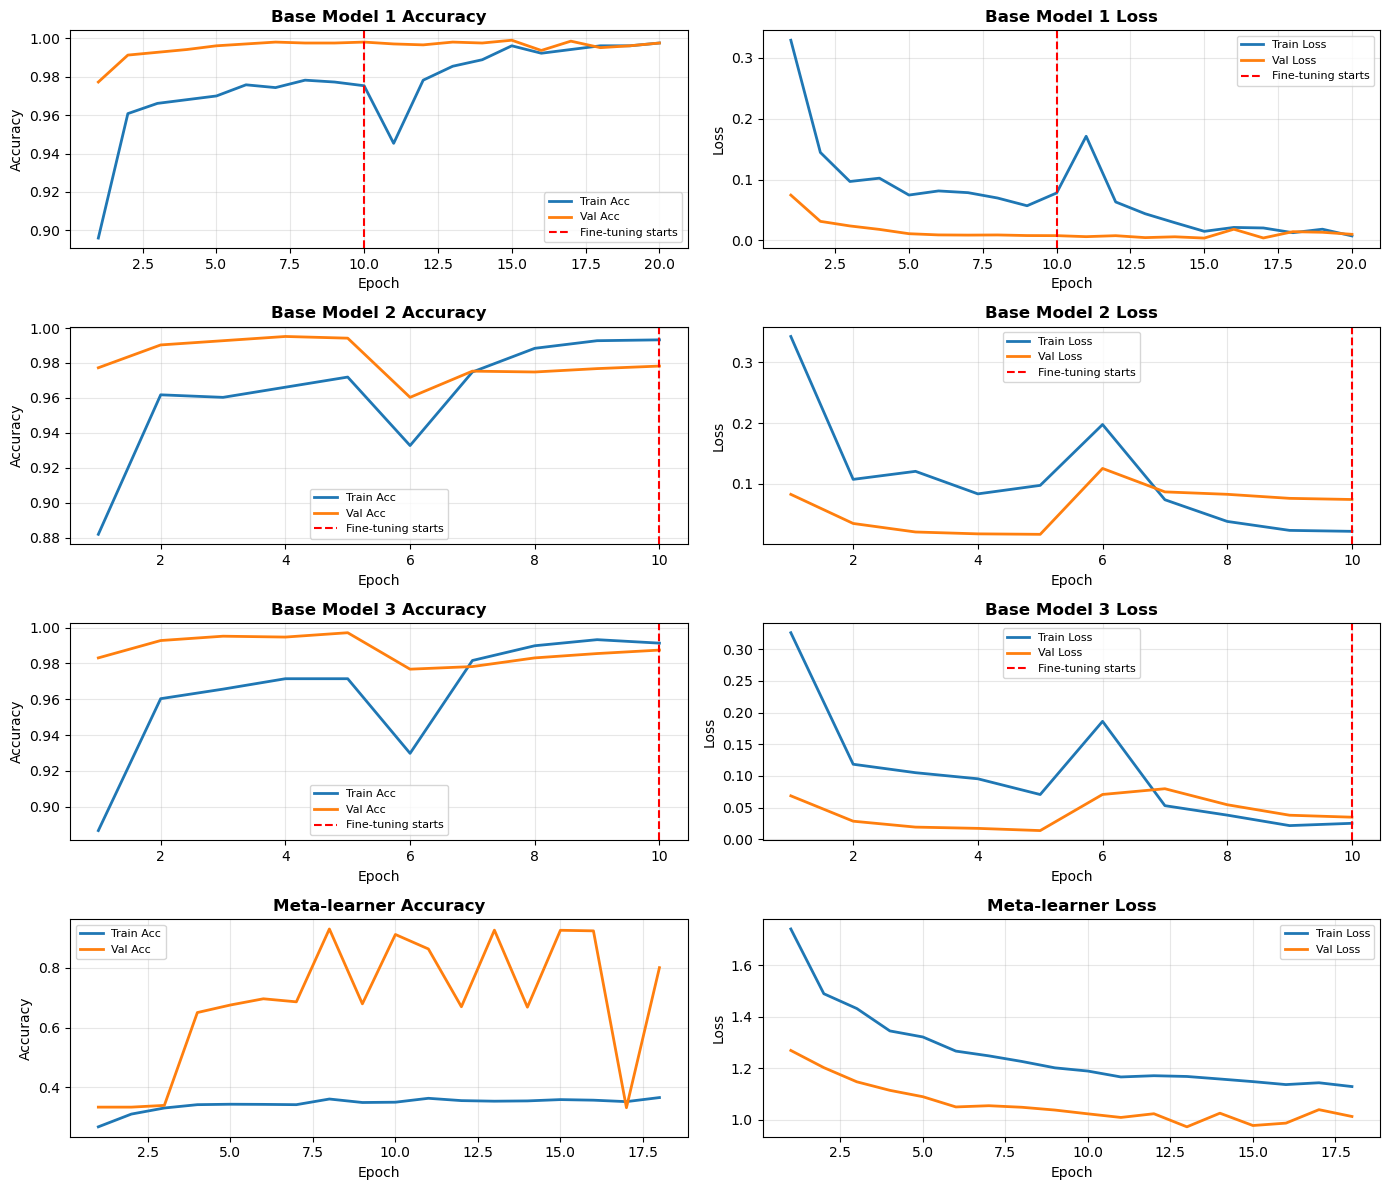

In [11]:
def plot_all_histories(base_histories, history_meta, initial_epochs, save_path=None):
    """
    base_histories: list of dicts with keys
        'accuracy', 'val_accuracy', 'loss', 'val_loss'
    history_meta: Keras History object for meta-learner
    save_path: Path to save the figure
    """
    n_base = len(base_histories)
    total_models = n_base + 1  # base models + meta-learner

    plt.figure(figsize=(14, 4 + 2 * total_models))

    # Base models
    for i, h in enumerate(base_histories):
        epochs = range(1, len(h['accuracy']) + 1)

        plt.subplot(total_models, 2, 2 * i + 1)
        plt.plot(epochs, h['accuracy'], label='Train Acc', linewidth=2)
        plt.plot(epochs, h['val_accuracy'], label='Val Acc', linewidth=2)
        plt.axvline(x=initial_epochs, color='r', linestyle='--', label='Fine-tuning starts')
        plt.title(f'Base Model {i+1} Accuracy', fontweight='bold')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.grid(True, alpha=0.3)
        plt.legend(fontsize=8)

        plt.subplot(total_models, 2, 2 * i + 2)
        plt.plot(epochs, h['loss'], label='Train Loss', linewidth=2)
        plt.plot(epochs, h['val_loss'], label='Val Loss', linewidth=2)
        plt.axvline(x=initial_epochs, color='r', linestyle='--', label='Fine-tuning starts')
        plt.title(f'Base Model {i+1} Loss', fontweight='bold')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True, alpha=0.3)
        plt.legend(fontsize=8)

    # Meta-learner
    m_epochs = range(1, len(history_meta.history['accuracy']) + 1)
    idx = n_base  # last row index

    plt.subplot(total_models, 2, 2 * idx + 1)
    plt.plot(m_epochs, history_meta.history['accuracy'], label='Train Acc', linewidth=2)
    plt.plot(m_epochs, history_meta.history['val_accuracy'], label='Val Acc', linewidth=2)
    plt.title('Meta-learner Accuracy', fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=8)

    plt.subplot(total_models, 2, 2 * idx + 2)
    plt.plot(m_epochs, history_meta.history['loss'], label='Train Loss', linewidth=2)
    plt.plot(m_epochs, history_meta.history['val_loss'], label='Val Loss', linewidth=2)
    plt.title('Meta-learner Loss', fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=8)

    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Training history plot saved to: {save_path}")
    
    plt.show()
    plt.close()

# Call with save path
plot_all_histories(
    base_histories, 
    history_meta, 
    initial_epochs,
    save_path=os.path.join(output_dir, "training_history_all_models.png")
)

✓ Base model 1 history saved to: output_graphs/base_model_1_history.png


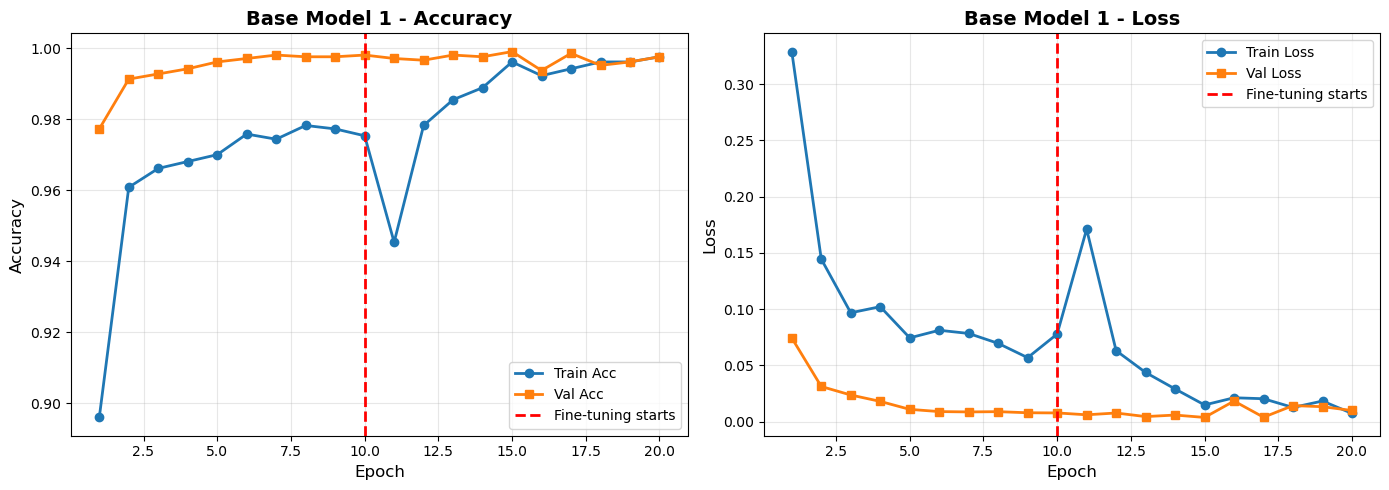

✓ Base model 2 history saved to: output_graphs/base_model_2_history.png


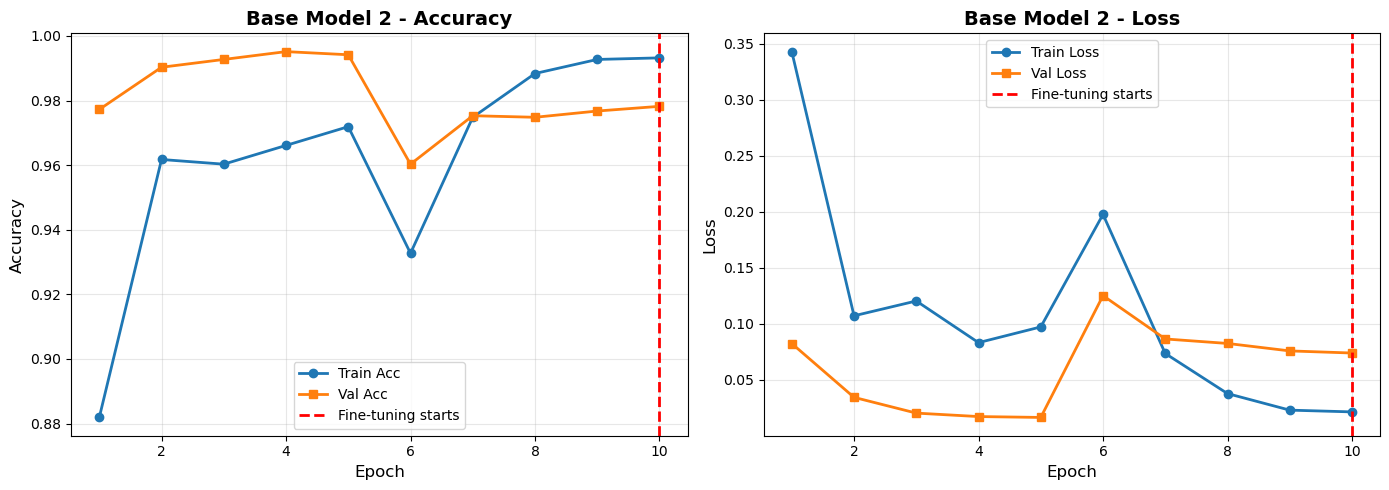

✓ Base model 3 history saved to: output_graphs/base_model_3_history.png


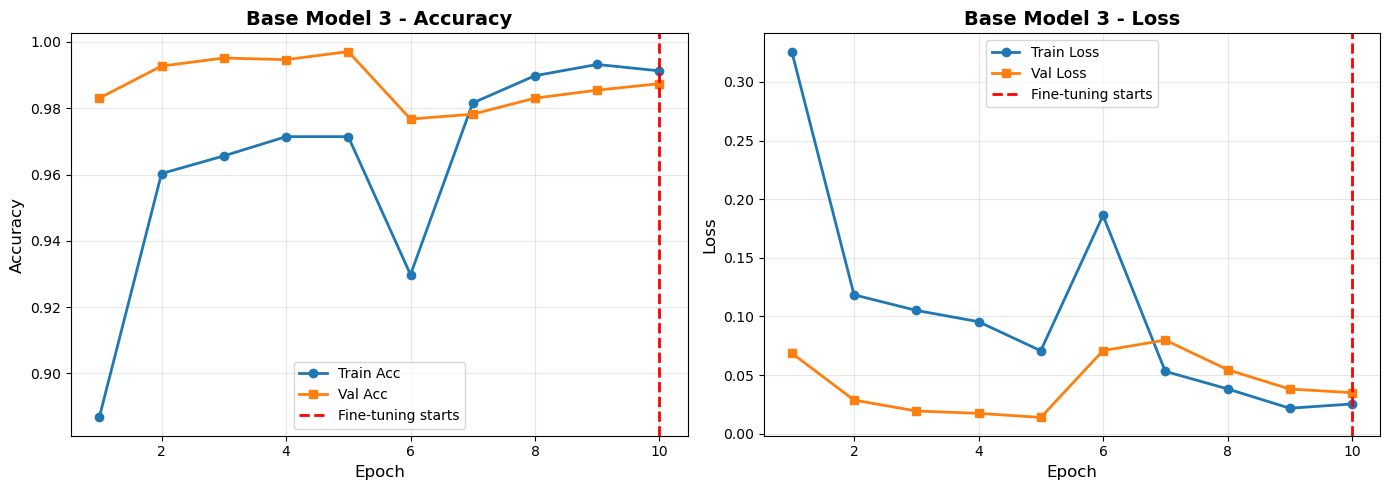

In [12]:
def plot_individual_base_history(history, model_num, initial_epochs, save_dir):
    """
    Plot and save individual base model training history
    """
    epochs = range(1, len(history['accuracy']) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy
    ax1.plot(epochs, history['accuracy'], label='Train Acc', linewidth=2, marker='o')
    ax1.plot(epochs, history['val_accuracy'], label='Val Acc', linewidth=2, marker='s')
    ax1.axvline(x=initial_epochs, color='r', linestyle='--', linewidth=2, label='Fine-tuning starts')
    ax1.set_title(f'Base Model {model_num} - Accuracy', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Loss
    ax2.plot(epochs, history['loss'], label='Train Loss', linewidth=2, marker='o')
    ax2.plot(epochs, history['val_loss'], label='Val Loss', linewidth=2, marker='s')
    ax2.axvline(x=initial_epochs, color='r', linestyle='--', linewidth=2, label='Fine-tuning starts')
    ax2.set_title(f'Base Model {model_num} - Loss', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    save_path = os.path.join(save_dir, f"base_model_{model_num}_history.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✓ Base model {model_num} history saved to: {save_path}")
    
    plt.show()
    plt.close()

# Save individual base model histories
for i, h in enumerate(base_histories):
    plot_individual_base_history(h, i+1, initial_epochs, output_dir)


✓ Meta-learner history saved to: output_graphs/meta_learner_history.png


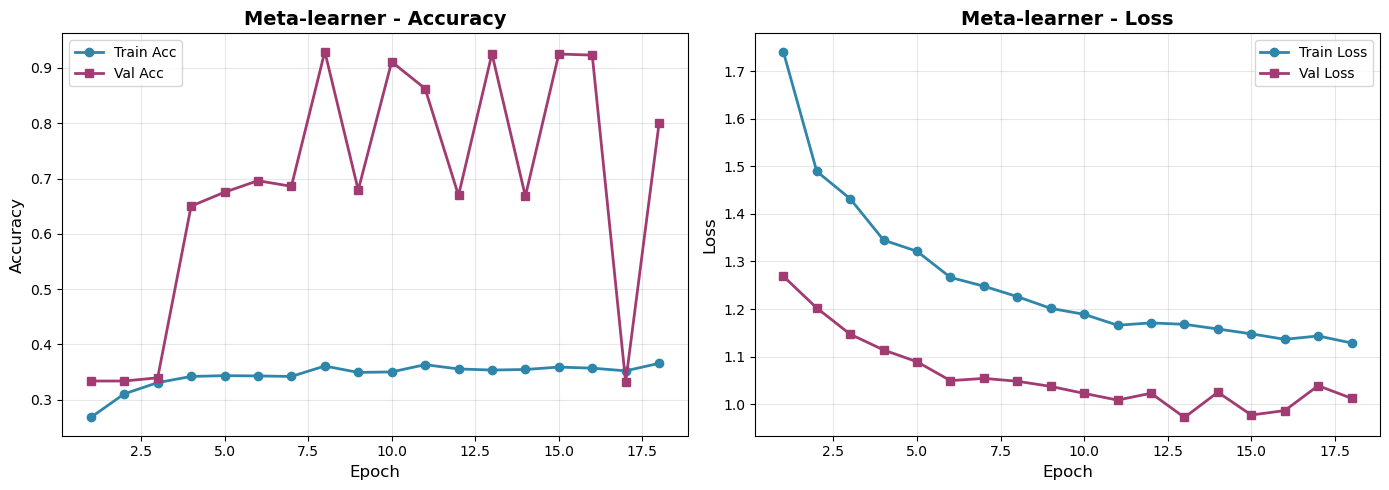

In [13]:
def plot_meta_history(history_meta, save_dir):
    """
    Plot and save meta-learner training history
    """
    epochs = range(1, len(history_meta.history['accuracy']) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy
    ax1.plot(epochs, history_meta.history['accuracy'], label='Train Acc', 
             linewidth=2, marker='o', color='#2E86AB')
    ax1.plot(epochs, history_meta.history['val_accuracy'], label='Val Acc', 
             linewidth=2, marker='s', color='#A23B72')
    ax1.set_title('Meta-learner - Accuracy', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Loss
    ax2.plot(epochs, history_meta.history['loss'], label='Train Loss', 
             linewidth=2, marker='o', color='#2E86AB')
    ax2.plot(epochs, history_meta.history['val_loss'], label='Val Loss', 
             linewidth=2, marker='s', color='#A23B72')
    ax2.set_title('Meta-learner - Loss', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    save_path = os.path.join(save_dir, "meta_learner_history.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✓ Meta-learner history saved to: {save_path}")
    
    plt.show()
    plt.close()

plot_meta_history(history_meta, output_dir)


In [14]:
meta_model.save('mask_detection_meta_ensemble.keras')
print("\n" + "="*70)
print("✓ Meta-learner model saved as 'mask_detection_meta_ensemble.keras'")
print("="*70 + "\n")


✓ Meta-learner model saved as 'mask_detection_meta_ensemble.keras'



In [15]:
def df_to_simple_markdown(df, include_index=True):
    cols = list(df.columns)
    lines = []
    if include_index:
        header = "| " + " | ".join(["index"] + cols) + " |"
        sep = "| " + " | ".join(["---"] * (len(cols) + 1)) + " |"
        lines.append(header)
        lines.append(sep)
        for idx, row in df.iterrows():
            row_vals = [str(idx)] + [str(v) for v in row.values]
            lines.append("| " + " | ".join(row_vals) + " |")
    else:
        header = "| " + " | ".join(cols) + " |"
        sep = "| " + " | ".join(["---"] * len(cols)) + " |"
        lines.append(header)
        lines.append(sep)
        for _, row in df.iterrows():
            row_vals = [str(v) for v in row.values]
            lines.append("| " + " | ".join(row_vals) + " |")
    return "\n".join(lines)

print("\nConfusion Matrix (Markdown):\n")
cm_markdown = df_to_simple_markdown(cm_df, include_index=True)
print(cm_markdown)

print("\nPer-class Accuracy (Markdown):\n")
per_class_markdown = df_to_simple_markdown(per_class_df, include_index=False)
print(per_class_markdown)

# Save tables to files
cm_df.to_csv(os.path.join(output_dir, "confusion_matrix.csv"))
per_class_df.to_csv(os.path.join(output_dir, "per_class_accuracy.csv"), index=False)

with open(os.path.join(output_dir, "confusion_matrix.md"), 'w') as f:
    f.write(cm_markdown)
    
with open(os.path.join(output_dir, "per_class_accuracy.md"), 'w') as f:
    f.write(per_class_markdown)

print(f"\n✓ Tables saved to {output_dir}/ as CSV and Markdown files")



Confusion Matrix (Markdown):

| index | pred_incorrect_mask | pred_with_mask | pred_without_mask |
| --- | --- | --- | --- |
| true_incorrect_mask | 540 | 134 | 16 |
| true_with_mask | 1 | 689 | 0 |
| true_without_mask | 3 | 0 | 683 |

Per-class Accuracy (Markdown):

| class | samples | accuracy | accuracy_percent |
| --- | --- | --- | --- |
| .ipynb_checkpoints | 0 | nan | nan |
| incorrect_mask | 690 | 0.782608695652174 | 78.26086956521739 |
| with_mask | 690 | 0.9985507246376811 | 99.85507246376811 |
| without_mask | 686 | 0.9956268221574344 | 99.56268221574344 |

✓ Tables saved to output_graphs/ as CSV and Markdown files


In [16]:
print("\n" + "="*70)
print("SUMMARY OF SAVED FILES")
print("="*70)
print(f"\nGraphs saved in '{output_dir}/':")
print("  1. confusion_matrix.png")
print("  2. per_class_accuracy.png")
print("  3. training_history_all_models.png")
for i in range(n_base):
    print(f"  {4+i}. base_model_{i+1}_history.png")
print(f"  {4+n_base}. meta_learner_history.png")

print(f"\nData files saved in '{output_dir}/':")
print("  1. confusion_matrix.csv")
print("  2. confusion_matrix.md")
print("  3. per_class_accuracy.csv")
print("  4. per_class_accuracy.md")

print("\nModel files saved in root directory:")
for i in range(n_base):
    print(f"  {i+1}. base_model_{i+1}.keras")
print(f"  {n_base+1}. meta_learner.keras")
print(f"  {n_base+2}. mask_detection_meta_ensemble.keras")

print("\n" + "="*70)
print(" ALL PROCESSES COMPLETED SUCCESSFULLY!")
print(" ALL GRAPHS SAVED SUCESSFULLY!")


SUMMARY OF SAVED FILES

Graphs saved in 'output_graphs/':
  1. confusion_matrix.png
  2. per_class_accuracy.png
  3. training_history_all_models.png
  4. base_model_1_history.png
  5. base_model_2_history.png
  6. base_model_3_history.png
  7. meta_learner_history.png

Data files saved in 'output_graphs/':
  1. confusion_matrix.csv
  2. confusion_matrix.md
  3. per_class_accuracy.csv
  4. per_class_accuracy.md

Model files saved in root directory:
  1. base_model_1.keras
  2. base_model_2.keras
  3. base_model_3.keras
  4. meta_learner.keras
  5. mask_detection_meta_ensemble.keras

 ALL PROCESSES COMPLETED SUCCESSFULLY!
 ALL GRAPHS SAVED SUCESSFULLY!
